# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

### Import libraries & read in the IBM data 

In [1034]:
import sys
data_dir = '../data/'
test_dir = '../tests/'
sys.path.append(data_dir)
sys.path.append(test_dir)

In [1035]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

In [1036]:
# Read in the data
df = pd.read_csv(data_dir+'user-item-interactions.csv')
df_content = pd.read_csv(data_dir+'articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [1037]:
df.shape

(45993, 3)

In [1038]:
df['email'].nunique()

5148

In [1039]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [1040]:
df_content.shape

(1056, 5)

#### check overlap of article ids in both datasets

In [1032]:
# It seems that we don't have the descriptions of all the articles listed in df
df_article_id_set = set(df['article_id'].astype(int))
df_content_article_id_set = set(df_content['article_id'].astype(int))
print(len(df_article_id_set), len(df_content_article_id_set))

714 1051


In [1078]:
#check which user articles are not present in the content file 
diff = df_article_id_set.difference(df_content_article_id_set)
list(diff)[:5], list(diff)[-5:]

([1051, 1052, 1053, 1054, 1055], [1440, 1441, 1442, 1443, 1444])

In [1046]:
len(diff)

277

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [999]:
# Distribution of articles read by user
count_articles_by_user = df.groupby('email')['article_id'].count().sort_values(ascending=False)
count_articles_by_user

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
1b520f0f65c0aee52d4235f92fb2de58fa966635      1
7a67e4a2902a20062e1f2a6835b6e099b34b4f6c      1
c4b7e639e91b1d18e5b9c000f0ad3354888fcdde      1
7a7fb282789944665ffc1cddee5ddbdbd7ca9f64      1
9655144418d25a0e074616840447e6e5dbef0069      1
Name: article_id, Length: 5148, dtype: int64

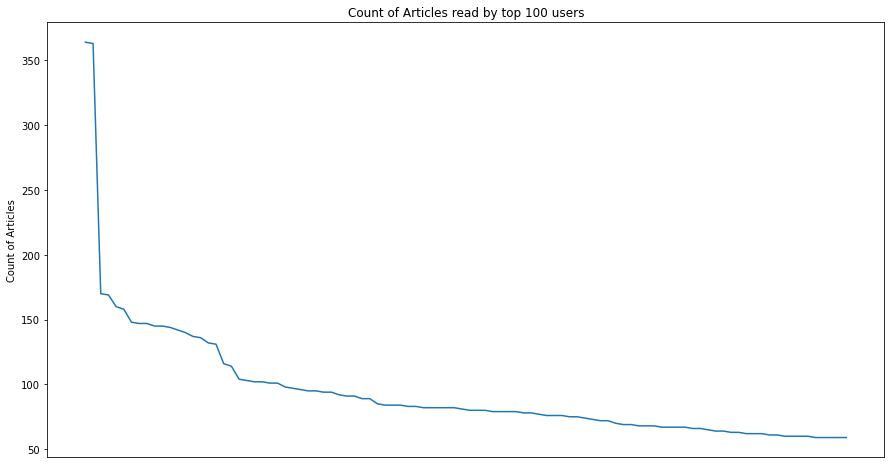

In [1090]:
# Plot count of articles read by user
ax = count_articles_by_user[:100].plot(figsize=(15,8))
ax.get_xaxis().set_visible(False)
ax.title.set_text('Count of Articles read by top 100 users')
ax.set_ylabel('Count of Articles')
plt.show()

In [1001]:
# Fill in the median and maximum number of user_article interactios below

median_val = count_articles_by_user.median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = count_articles_by_user.max() # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [1002]:
# Find and explore duplicate articles
df_content.duplicated(subset=['article_id']).sum()

5

In [1003]:
df_content[df_content.duplicated(subset=['article_id'], keep=False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [1004]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep= 'first')
df_content.duplicated(subset=['article_id']).sum()

0

In [1009]:
df_content['article_id'] 

0          0
1          1
2          2
3          3
4          4
        ... 
1051    1046
1052    1047
1053    1048
1054    1049
1055    1050
Name: article_id, Length: 1051, dtype: int64

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [956]:
count_user_by_article = df.groupby('article_id')['email'].count().sort_values(ascending=False)
a = sum(count_user_by_article > 0)
a

714

In [957]:
count_user_by_article

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1113.0      1
1119.0      1
984.0       1
1127.0      1
1266.0      1
Name: email, Length: 714, dtype: int64

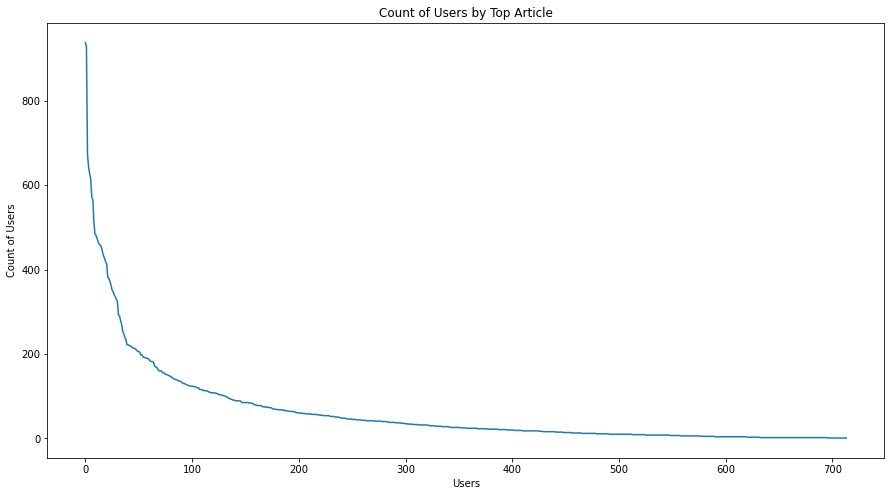

In [1092]:
ax = count_user_by_article.to_frame().reset_index()['email'].plot(figsize=(15,8))
ax.title.set_text('Count of Users by Top Article')
ax.set_ylabel('Count of Users')
ax.set_xlabel('Users')
plt.show()

#### The number of unique articles in the dataset (whether they have any interactions or not).

In [959]:
b = df_content['article_id'].nunique()
b

1051

#### The number of unique users in the dataset. (excluding null values)

In [960]:
c = df['email'].nunique()
c

5148

#### The number of user-article interactions in the dataset.

In [961]:
d = df.shape[0]
d

45993

#### Results

In [962]:
unique_articles = a # The number of unique articles that have at least one interaction
total_articles = b # The number of unique articles on the IBM platform
unique_users = c # The number of unique users
user_article_interactions = d # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [963]:
most_viewed_article_id = str(count_user_by_article.index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = count_user_by_article.iloc[0] # The most viewed article in the dataset was viewed how many times?|

In [964]:
most_viewed_article_id

'1429.0'

In [965]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded
df['article_id'] = df['article_id'].astype(int)

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [966]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

sol_1_dict

{'`50% of individuals have _____ or fewer interactions.`': 3.0,
 '`The total number of user-article interactions in the dataset is ______.`': 45993,
 '`The maximum number of user-article interactions by any 1 user is ______.`': 364,
 '`The most viewed article in the dataset was viewed _____ times.`': 937,
 '`The article_id of the most viewed article is ______.`': '1429.0',
 '`The number of unique articles that have at least 1 rating ______.`': 714,
 '`The number of unique users in the dataset is ______`': 5148,
 '`The number of unique articles on the IBM platform`': 1051}

In [967]:
# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [968]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_gpby = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)
    top_articles_gpby.index[:n].tolist()
    
    # Return the top article titles from df (not df_content)
    return top_articles_gpby.index[:n].tolist() 

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_gpby = df.groupby('title')['user_id'].count().sort_values(ascending=False)
 
    return top_articles_gpby.index[:n].tolist() # Return the top article ids

In [969]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles, test_dir)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [970]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = (df.groupby(['user_id', 'article_id'])['article_id'].count())
    user_item = user_item.unstack().reset_index().fillna(0).set_index('user_id')
    user_item = user_item.applymap(lambda x: 1 if x > 1 else x)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [971]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [972]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # sort by similarity
    # create list of just the ids  
    user_user_dot_product = user_item.loc[user_id,:].dot(user_item.T).sort_values(ascending=False)
    most_similar_users = user_user_dot_product.index.to_list()
       
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [973]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [974]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    mask = df['article_id'].isin(article_ids)
    article_names = list(set(df[mask]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    mask = user_item.loc[user_id,:] > 0
    article_ids = mask[mask].index.to_list()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users_l = find_similar_users(user_id)
    user_id_article_l = get_user_articles(user_id)[0]
    article_recs_l = []

    for u in similar_users_l:
        user_article_l = get_user_articles(u)[0]
        user_article_l = [ i for i in user_article_l if i is not user_id_article_l ]
        article_recs_l.extend(user_article_l)
        if len(user_article_l) > m:
            recs = user_article_l[:m]
            return recs # return your recommendations for this user_id    

In [975]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['python for loops explained (python for data science basics #5)',
 'sector correlations shiny app',
 'deep learning with tensorflow course by big data university',
 'introducing ibm watson studio ',
 'introduction to market basket analysis in\xa0python',
 'new shiny cheat sheet and video tutorial',
 'tidyverse practice: mapping large european cities',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'tensorflow quick tips',
 'time series prediction using recurrent neural networks (lstms)']

In [976]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [977]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here  
    user_user_dot_product = user_item.loc[user_id,:].dot(user_item.T)
    count_articles_by_user = df.groupby('user_id')['article_id'].count()
    neighbors_df = pd.merge(user_user_dot_product, count_articles_by_user, left_index=True, right_index=True)
    neighbors_df = neighbors_df.rename(columns={neighbors_df.columns[0]: "similarity", neighbors_df.columns[1]: "num_interactions"})
    neighbors_df = neighbors_df.drop(user_id, axis = 0)
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here    
    similar_users_l = get_top_sorted_users(user_id).index.to_list()
    user_id_article_l = get_user_articles(user_id)[0]
    article_recs_l = []

    for u in similar_users_l:
        user_article_l = get_user_articles(u)[0]
        user_article_l = [ i for i in user_article_l if i is not user_id_article_l ]
        article_recs_l.extend(user_article_l)
        if len(user_article_l) > m:
            recs = user_article_l[:m]
            rec_names = get_article_names(recs)
            return recs, rec_names # return your recommendations for this user_id        

In [978]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12, 109, 125, 142, 164, 205, 232, 302, 336, 362]

The top 10 recommendations for user 20 are the following article names:
['self-service data preparation with ibm data refinery', 'neural networks for beginners: popular types and applications', 'challenges in deep learning', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'tensorflow quick tips', 'dsx: hybrid mode', 'timeseries data analysis of iot events by using jupyter notebook', 'statistics for hackers']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [979]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index.to_list()[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index.to_list()[9] # Find the 10th most similar user to user 131

In [980]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

__We wouldn't have any data or articles referenced by this user. This would be a cold start problem. One approach would be to recommend the overall top articles viewed by users (knowledge base recommendations)__

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [981]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = count_user_by_article.index.to_list()[:10] # Your recommendations here

In [982]:
assert set(new_user_recs) == set([1314,1429,1293,1427,1162,1364,1304,1170,1431,1330]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

> One content base approach that I explore below relies on the hypothesis that there is a correlation between article length/reading time and their popularity. Unfortunately, the analysis seems to show a fairly weak correlation. In addition not all user articles are present in the article content dataframe.

#### High level analysis and plot distribution of article length 

In [983]:
# count the number of words per article
df_content.set_index('article_id')
df_content['body_word_count'] = df_content['doc_body'].str.split().str.len()
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,body_word_count
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,681.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,3430.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,806.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,285.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,644.0


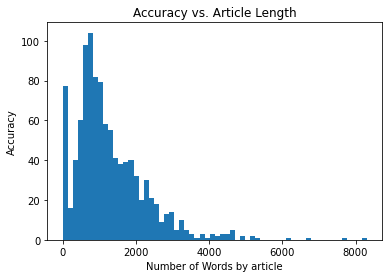

In [984]:
# Show the distribution of words per article
df_content['body_word_count'].plot.hist(bins=60)
plt.xlabel('Number of Words by article');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Article Length');
plt.show()

In [985]:
# Plot summary statistics of the article length
df_content['body_word_count'].describe()

count    1037.000000
mean     1294.661524
std       997.688855
min         1.000000
25%       653.000000
50%      1037.000000
75%      1769.000000
max      8308.000000
Name: body_word_count, dtype: float64

The articles have an average of 1300 words and a pretty large standard deviation of 1000 words. We can see that many articles are very close to 0 in length while other reach over 8000 words!

Let's see if there is correlation between article length and popularity

In [986]:
# Plot correlation between article length and popularity (number of users viewed)
count_user_by_article_df = df.groupby('article_id')['user_id'].count().to_frame()
count_user_by_article_df = count_user_by_article_df.rename(columns={count_user_by_article_df.columns[0]: "count_user"})
a = pd.merge(df_content, count_user_by_article_df, left_index=True, right_index=True)
a.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,body_word_count,count_user
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,681.0,14
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,806.0,58
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,644.0,13
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8,629.0,85
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9,1406.0,10


In [917]:
features = ['body_word_count','count_user']
df_content[features].sort_values(by = 'count_user', ascending = False)[:50].mean()

body_word_count    1523.22449
count_user          179.32000
dtype: float64

The top 50 articles by popularity have lengths slightly above the average of words for all the article corpus

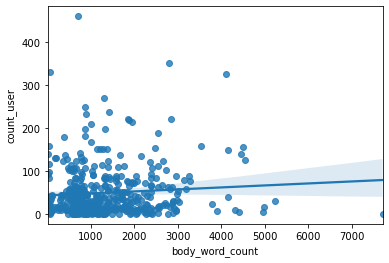

In [865]:
sns.regplot(x="body_word_count", y="count_user", data=df_content)
plt.show()

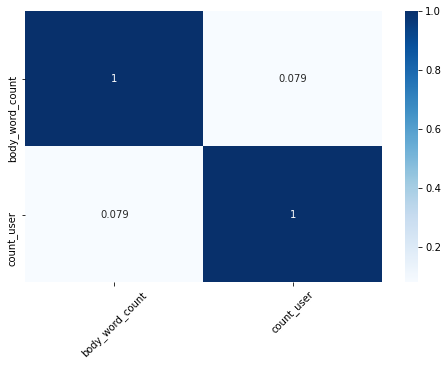

In [866]:
# Correlations between selected features and response
fig = plt.figure(figsize=(8, 5))

sns.heatmap(df_content[features].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()

Unfortunately, there is a low to moderate correlation between popularity of articles and their length. 

#### Conclusion

While are previous analysis was inconclusive, adding a criteria on approximate reading time by article could help improve the user experience and help provide recommendations if IBM collected users preferences.

Example <img src="../images/estimated_reading_time.PNG" width="400" height="400">

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [399]:
# Load the matrix here
user_item_matrix = pd.read_pickle(test_dir+'user_item_matrix.p')

In [400]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [401]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

> We are assuming that there are no missing values in the dataset and therefore the SVD factorization will converge

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

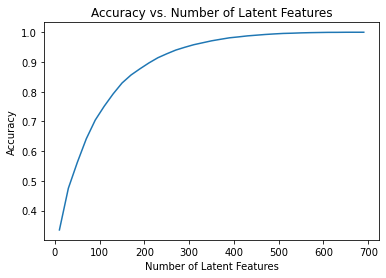

In [402]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

#### Identify users we can make predictions for in the test set

In [419]:
user_item_train = create_user_item_matrix(df_train)
user_item_test = create_user_item_matrix(df_test)
test_user_set = set(user_item_test.index.to_list())
train_user_set = set(user_item_train.index.to_list())

In [666]:
intersection = test_user_set.intersection(train_user_set)
num_test_users = len(intersection)
test_users_l = list(intersection)

print(num_test_users, test_users_l)

20 [3968, 4487, 4231, 3093, 3989, 3990, 3740, 3998, 4002, 4274, 3777, 4293, 3527, 3532, 3024, 3801, 3684, 2917, 4204, 3193]


#### Identify articles we can make predictions for in the test set

In [669]:
test_articles_set = set(user_item_test.columns.to_list())
train_articles_set = set(user_item_train.columns.to_list())

In [668]:
intersection = test_articles_set.intersection(train_articles_set)
num_test_articles = len(intersection)
test_articles_l = list(intersection)

print(num_test_articles, test_articles_l)

574 [0, 2, 4, 8, 9, 12, 14, 15, 16, 18, 20, 25, 26, 28, 29, 30, 32, 33, 34, 36, 39, 40, 43, 48, 50, 51, 53, 54, 57, 58, 59, 60, 62, 64, 65, 68, 74, 76, 77, 78, 80, 81, 82, 87, 89, 92, 96, 98, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 120, 122, 124, 125, 130, 131, 132, 134, 136, 138, 142, 143, 145, 146, 151, 152, 153, 157, 158, 162, 164, 173, 176, 181, 183, 184, 188, 189, 191, 193, 194, 195, 202, 205, 210, 213, 215, 221, 223, 224, 225, 230, 232, 233, 234, 236, 237, 239, 240, 241, 244, 250, 251, 252, 253, 254, 256, 258, 260, 263, 266, 268, 270, 273, 277, 278, 283, 284, 288, 291, 295, 297, 298, 299, 302, 303, 310, 311, 313, 314, 315, 316, 323, 324, 329, 336, 337, 339, 346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 359, 362, 367, 369, 373, 376, 379, 381, 382, 383, 384, 389, 390, 395, 398, 399, 404, 409, 411, 412, 415, 420, 422, 426, 427, 437, 440, 444, 448, 455, 460, 462, 463, 464, 465, 468, 470, 473, 475, 477, 480, 482, 485, 486, 491, 494, 495, 499, 500, 508

In [410]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.to_list()
    test_arts = user_item_test.columns.to_list()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [426]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [588]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)  # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

#### Use SVD decomposition in the predict_articles function to predict article for a user id

In [721]:
def predict_articles(user_item_df, user_matrix, s_matrix, article_matrix, user_id, verbose = False):
    '''
    INPUT:
    user_item_df - original user-item dataframe
    user_matrix - user by latent factor matrix
    s_matrix - latent fatcors sigma matrix
    article_matrix - latent factor by movie matrix
    user_id - the user_id to predict articles for
    
    OUTPUT:
    pred - the predicted rating for user_id-article_id according to SVD and k latent factors
    '''
    if verbose:
        print("predict_articles -> user id = {} with shape of SVD matrices U {} S {} VT {}".
              format(user_id, user_matrix.shape, s_matrix.shape, article_matrix.shape))
    
    # All user predictions
    user_article_preds = np.around(np.dot(np.dot(user_matrix, s_matrix), article_matrix))
    
    # Create df from matrix - easier to manipulate
    user_article_preds_df = pd.DataFrame(user_article_preds, columns = user_item_df.columns, index = user_item_df.index) 
    
    # predictions for userid
    mask = user_article_preds_df.loc[user_id] > 0
    preds = user_article_preds_df.columns[mask].to_list()
    
    if verbose:
        print("predict_articles -> user id = {} predicted articles {}".
              format(user_id, preds))
    
    return preds

In [730]:
# test function with a specific user id 
user_id = 3193
k = 500
s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
pred_articles = predict_articles(user_item_df = user_item_train, user_matrix = u_new, 
                     s_matrix = s_new, article_matrix = vt_new, user_id = u_id , verbose = True)

#check with training set
mask = user_item_train.loc[user_id,:] > 0
print(user_item_train.columns[mask].to_list())

predict_articles -> user id = 3193 with shape of SVD matrices U (4487, 500) S (500, 500) VT (500, 714)
predict_articles -> user id = 3193 predicted articles [1398]
[1398]


### Define an evaluation function that takes a training user id list, makes predictions and evaluates against test set results

In [731]:
def evaluate_predictions(test_user_list, user_matrix, s_matrix, article_matrix, verbose = False): 
    '''
    INPUT:
    test_user_list - list of test user ids to predict articles for and evaluate 
    user_matrix - user by latent factor matrix
    s_matrix - latent fatcors sigma matrix
    article_matrix - latent factor by movie matrix
    
    OUTPUT:
    total_res - the proprotion of successful article predictions accross the user list provided (%)
    '''
    
    total_predictable_articles = 0
    total_properly_predicted_articles = 0

    for u_id in test_user_list:
        if verbose:
            print("\n *** Evaluating predictions for user {}".format(u_id)) 
        # predict articles
        pred_articles = predict_articles(user_item_df = user_item_train, user_matrix = user_matrix, 
                             s_matrix = s_matrix, article_matrix = article_matrix, user_id = u_id)
        if verbose:
            print("Predicted articles -> {}".format(pred_articles))

        # check test dataset 
        mask = user_item_test.loc[u_id,:] > 0
        actual_articles = user_item_test.columns[mask].to_list() 
        actual_predictable_articles =  list(set(actual_articles).intersection(set(test_articles_l)))
        if verbose:
            print("Actual predictable articles -> {}".format(actual_predictable_articles))

        # Results
        properly_predicted_articles = list(set(actual_articles).intersection(set(pred_articles)))
        num_properly_predicted_articles = len(properly_predicted_articles)
        num_actual_predictable_articles = len(actual_predictable_articles)
        user_res = num_properly_predicted_articles / num_actual_predictable_articles * 100
        if verbose:
            print("Successful article predictions -> {} -> {}%".format(properly_predicted_articles, round(user_res,2)))

        total_predictable_articles += num_actual_predictable_articles
        total_properly_predicted_articles += num_properly_predicted_articles

    total_res = total_properly_predicted_articles / total_predictable_articles * 100   
    
    if verbose:
        print(" \n\n === Proportion of successful predictions for {} users -> {}%".format(len(test_users_l), round(total_res,2)))
    
    return total_res

In [733]:
# Test evaluation Function with test users list
k = 100
s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
evaluate_predictions(test_user_list = test_users_l, user_matrix = u_new, s_matrix = s_new, article_matrix = vt_new, verbose = True)


 *** Evaluating predictions for user 3968
Predicted articles -> [194, 651, 730, 865, 1054, 1174, 1176, 1274, 1314, 1330, 1332, 1393]
Actual predictable articles -> [1314, 996, 43, 684, 268, 1429, 1018, 348]
Successful article predictions -> [1314] -> 12.5%

 *** Evaluating predictions for user 4487
Predicted articles -> [542, 730, 1166, 1274, 1314, 1423, 1431]
Actual predictable articles -> [1176, 1314, 1053, 1424]
Successful article predictions -> [1314] -> 25.0%

 *** Evaluating predictions for user 4231
Predicted articles -> [43, 98, 1172, 1185, 1398, 1429]
Actual predictable articles -> [444, 58, 1189, 102, 681, 969, 43, 1324, 667, 78, 244, 1398, 1431, 1018, 1403, 1436]
Successful article predictions -> [43, 1398] -> 12.5%

 *** Evaluating predictions for user 3093
Predicted articles -> [33, 124, 202, 349, 795, 1017, 1170]
Actual predictable articles -> [194, 151, 1017, 1436, 957]
Successful article predictions -> [1017] -> 20.0%

 *** Evaluating predictions for user 3989
Predicte

11.009174311926607

#### Now Evaluate predictions of test user list for multiple k latent factors values

In [734]:
# loop through k, generate SV matrices, predict and evaluate test user ids - store results in a dictionnary 
results_dict = {}

for k in range(10,700,50):
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    res = evaluate_predictions(test_user_list = test_users_l, user_matrix = u_new, s_matrix = s_new, article_matrix = vt_new, verbose = False)
    results_dict[k] = round(res,2)
    print("*** k = {} : Proportion of successful predictions is {}% for matrices U:{} S:{} VT:{}".format(k, round(res,2), u_new.shape, s_new.shape, vt_new.shape))
              
print(results_dict)    

*** k = 10 : Proportion of successful predictions is 4.59% for matrices U:(4487, 10) S:(10, 10) VT:(10, 714)
*** k = 60 : Proportion of successful predictions is 9.63% for matrices U:(4487, 60) S:(60, 60) VT:(60, 714)
*** k = 110 : Proportion of successful predictions is 11.01% for matrices U:(4487, 110) S:(110, 110) VT:(110, 714)
*** k = 160 : Proportion of successful predictions is 11.93% for matrices U:(4487, 160) S:(160, 160) VT:(160, 714)
*** k = 210 : Proportion of successful predictions is 12.39% for matrices U:(4487, 210) S:(210, 210) VT:(210, 714)
*** k = 260 : Proportion of successful predictions is 12.39% for matrices U:(4487, 260) S:(260, 260) VT:(260, 714)
*** k = 310 : Proportion of successful predictions is 12.39% for matrices U:(4487, 310) S:(310, 310) VT:(310, 714)
*** k = 360 : Proportion of successful predictions is 12.39% for matrices U:(4487, 360) S:(360, 360) VT:(360, 714)
*** k = 410 : Proportion of successful predictions is 12.39% for matrices U:(4487, 410) S:(4

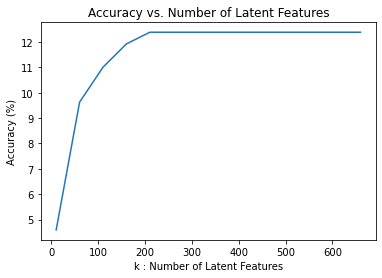

In [735]:
# Plot results stored in the dictionnary

lists = sorted(results_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xlabel('k : Number of Latent Features');
plt.ylabel('Accuracy (%)');
plt.title('Accuracy vs. Number of Latent Features');
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

> We can see that for the limited user list (20) we can test our predictions for, we quickly hit a low accuracy ceiling around 12.5% with aproximately 200 latent factors. This is a pretty poor results accuracy wise but it doesn't necessarily mean that there isn't an improvement to IBM's current user experience.
One clear possible improvement would be to categorize the articles by genres and topic (either by manually labelling these or using an undupervised method suchas LDA on the 'doc_full_name' field as an example) but also the length or estimated reading time. This could be estimated using the length of the 'doc_body' feature (see below for a quick overview of the distribution of the articles by word count) refer to the content base section Part IV discussion.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!
 

In [1072]:
# Build a simple graphical interface that takes a user id inputed and provided the top 5 article recommendations
import gradio as gr

def get_rec(user_id):
    res_list = get_article_names(user_user_recs(int(user_id), 5))
    res_str = 'Top 5 recommendations: \n->' + '\n->'.join(res_list)
    return (res_str)

iface = gr.Interface(
                      fn=get_rec, 
                      inputs=gr.inputs.Textbox(lines=2, placeholder="Enter a user id..."), 
                      outputs="text"
                    )

iface.launch()

Running locally at: http://127.0.0.1:7874/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7874/', None)

<img src="../images/simple_recommendation-app.PNG" />